In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings ('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

## Prepare the dataset for the model

In [114]:
df = pd.read_csv(r"past_data_clean.csv").set_index('Index')
df_prod = pd.read_csv(r"df_prod.csv").set_index('Index')

df_model = pd.concat([df, df_prod], axis=0)
df_model['date'] = pd.to_datetime(df_model['date'])
df_model

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,day,month,year,quarter,week
Index,,,,,,,,,,,,,,
511306,52,2,2013-01-01,0,0,0,1,1,0,1,1,2013,1,1
150763,677,2,2013-01-01,0,0,0,1,1,0,1,1,2013,1,1
633749,348,2,2013-01-01,0,0,0,1,1,0,1,1,2013,1,1
106460,966,2,2013-01-01,0,0,0,1,1,0,1,1,2013,1,1
278363,750,2,2013-01-01,0,0,0,1,1,0,1,1,2013,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369531,58,5,2015-07-31,603,1,1,0,0,8581,31,7,2015,3,31
161452,241,5,2015-07-31,763,1,1,0,1,8650,31,7,2015,3,31
242869,293,5,2015-07-31,878,1,1,0,1,7494,31,7,2015,3,31


In [115]:
df_model.shape

(628700, 14)

In [116]:
df_model.isna().sum().sum()

0

In [117]:
print(df_model['date'].min())
print(df_model['date'].max())

2013-01-01 00:00:00
2015-07-31 00:00:00


### Filter and engineer features

In [118]:
df_model = df_model[(df_model['open'] == 1) & (df_model['nb_customers_on_day'] > 0)]
df_model.shape

(531926, 14)

In [119]:
print(df_model['date'].min())
print(df_model['date'].max())

2013-01-01 00:00:00
2015-07-31 00:00:00


In [120]:
first_day_per_store = df_model.groupby('store_id')['date'].transform('min')
first_day_per_store.unique()

<DatetimeArray>
['2013-01-01 00:00:00', '2013-01-02 00:00:00', '2013-01-03 00:00:00',
 '2013-01-04 00:00:00', '2013-01-05 00:00:00', '2013-01-07 00:00:00',
 '2013-01-08 00:00:00', '2013-01-09 00:00:00', '2013-01-19 00:00:00',
 '2013-04-12 00:00:00', '2013-07-05 00:00:00', '2013-07-06 00:00:00']
Length: 12, dtype: datetime64[ns]

In [121]:
# Daily Lag Feature: shifts amount of sales from previous day
df_model['sales_lag_1'] = (
    df_model.groupby('store_id')['sales'].shift(1))
# Handle NaNs (first day per store)
first_day_per_store = df_model.groupby('store_id')['date'].transform('min')
first_day_mask = df_model['date'] == first_day_per_store
df_model.loc[first_day_mask, 'sales_lag_1'] = (
    df_model.loc[first_day_mask, 'sales_lag_1'].fillna(0))
# Fill NaNs in sales_lag_1 with forward fill (previous non-NaN value)
df_model['sales_lag_1'] = df_model['sales_lag_1'].fillna(method='ffill')

In [122]:
# Calculate average sales for the same month year by year
df_model['avg_sales_month'] = (
    df_model.groupby(['store_id', 'year', 'month'])['sales']
    .transform(lambda x: x.shift().mean()))
# Handle NaNs (first month per store)
first_day_per_store = df_model.groupby('store_id')['date'].transform('min')
first_day_mask = df_model['date'] == first_day_per_store
df_model.loc[first_day_mask, 'avg_sales_month'] = (
    df_model.loc[first_day_mask, 'avg_sales_month'].fillna(0))
# Fill NaNs in avg_sales_month with forward fill (previous non-NaN value)
df_model['avg_sales_month'] = df_model['avg_sales_month'].fillna(method='ffill')

In [123]:
# Calculate average sales for the same day of the week week by week
df_model['avg_sales_day_week'] = (
    df_model.groupby(['store_id', 'day_of_week'])['sales']
    .transform(lambda x: x.shift().expanding().mean()))
# Handle NaNs (first day per store)
first_day_per_store = df_model.groupby('store_id')['date'].transform('min')
first_day_mask = df_model['date'] == first_day_per_store
df_model.loc[first_day_mask, 'avg_sales_day_week'] = (
    df_model.loc[first_day_mask, 'avg_sales_day_week'].fillna(0))
# Fill NaNs in avg_sales_day_week with forward fill (previous non-NaN value)
df_model['avg_sales_day_week'] = df_model['avg_sales_day_week'].fillna(method='ffill')

In [124]:
df_model

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,day,month,year,quarter,week,sales_lag_1,avg_sales_month,avg_sales_day_week
Index,,,,,,,,,,,,,,,,,
580156,676,2,2013-01-01,777,1,0,1,1,3821,1,1,2013,1,1,0.0,3714.250000,0.000000
277247,274,2,2013-01-01,729,1,0,1,1,3102,1,1,2013,1,1,0.0,2321.631579,0.000000
253110,423,2,2013-01-01,1751,1,0,1,1,9643,1,1,2013,1,1,0.0,9029.000000,0.000000
239216,259,2,2013-01-01,1444,1,0,1,1,6851,1,1,2013,1,1,0.0,6651.176471,0.000000
60765,769,2,2013-01-01,1248,1,0,1,1,5035,1,1,2013,1,1,0.0,7629.285714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369531,58,5,2015-07-31,603,1,1,0,0,8581,31,7,2015,3,31,8433.0,6825.444444,6013.015625
161452,241,5,2015-07-31,763,1,1,0,1,8650,31,7,2015,3,31,6978.0,6396.857143,6869.000000
242869,293,5,2015-07-31,878,1,1,0,1,7494,31,7,2015,3,31,6748.0,6169.083333,5955.265823


In [125]:
df_model.isna().sum().sum()

0

In [126]:
df_model[['promotion','sales_lag_1','avg_sales_month','avg_sales_day_week']].describe()

,promotion,sales_lag_1,avg_sales_month,avg_sales_day_week
count,531926.000000,531926.000000,531926.000000,531926.000000
mean,0.446350,6939.250328,6908.235640,6722.291298
std,0.497114,3116.990677,2527.582819,2687.684990
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,4846.000000,5220.800000,5022.586714
50%,0.000000,6359.000000,6482.687500,6360.722008
75%,1.000000,8352.000000,8011.761161,7955.082261
max,1.000000,41551.000000,26723.818182,32263.000000


In [127]:
df_model.to_csv('df_model.csv')

In [128]:
df_model = pd.read_csv(r"df_model.csv").set_index('Index')
df_model['date'] = pd.to_datetime(df_model['date'])
df_model.shape

(531926, 17)

#### Check correlations

In [129]:
df_model.columns

Index(['store_id', 'day_of_week', 'date', 'nb_customers_on_day', 'open',
       'promotion', 'state_holiday', 'school_holiday', 'sales', 'day', 'month',
       'year', 'quarter', 'week', 'sales_lag_1', 'avg_sales_month',
       'avg_sales_day_week'],
      dtype='object')

In [130]:
# Checking if correlations have improved
metrics = df_model[['day_of_week', 'promotion', 'state_holiday', 'school_holiday', 'sales', 'day', 'month',
           'year', 'quarter', 'week', 'sales_lag_1','avg_sales_month', 'avg_sales_day_week']]
correlations = metrics.corr()['sales']
print(correlations.sort_values(ascending=False))

sales                 1.000000
avg_sales_month       0.813749
avg_sales_day_week    0.801890
sales_lag_1           0.730490
promotion             0.367124
week                  0.075460
month                 0.074500
quarter               0.062601
school_holiday        0.039942
year                  0.035969
state_holiday         0.022372
day                  -0.051746
day_of_week          -0.178175
Name: sales, dtype: float64


""" Key features to keep:
avg_sales_month       0.813749
avg_sales_day_week    0.801890
sales_lag_1           0.730490
promotion             0.367124
week                  0.0754605797
day_of_week          -0.178175
""" 

In [131]:
df_model_metrics = df_model[['date','sales', 'promotion', 'week', 'day_of_week',
                         'sales_lag_1', 'avg_sales_month', 'avg_sales_day_week']]
df_model_metrics.shape

(531926, 8)

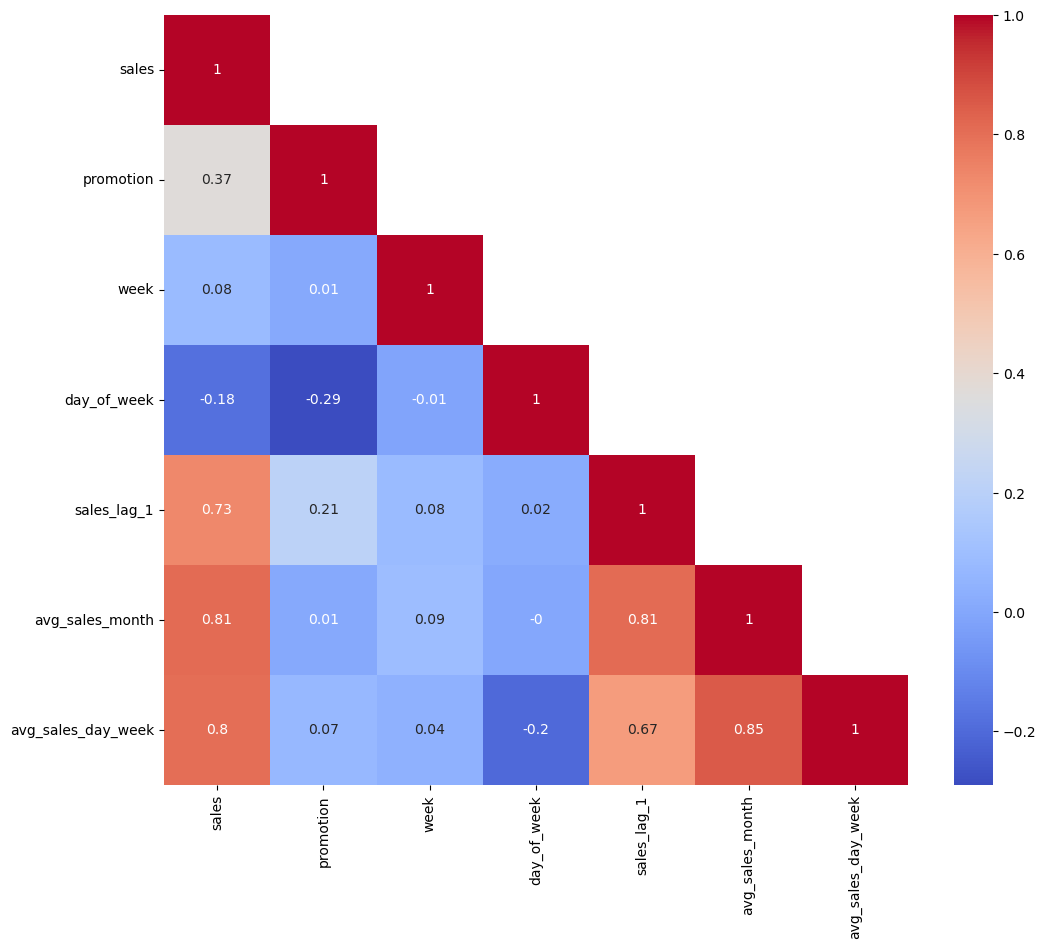

In [132]:
correlations_metrics = df_model_metrics.drop(['date'], axis=1)
correlations = round(correlations_metrics.corr(),2)

mask = np.zeros_like(correlations)
mask[np.triu_indices_from(mask, k=1)] = True

plt.figure(figsize=(12, 10)) 
sns.heatmap(correlations, mask=mask, annot=True, cmap="coolwarm")
plt.yticks(rotation=0)

plt.show()

# High correlation among features is a sign of multicollinearity, which can lead to overfitting. 
# When features are highly correlated, they provide redundant information that can make the model more complex without adding real predictive value.   

## Prediction of Sales

### Load dataset ready for the model

In [517]:
df_model = pd.read_csv(r"df_model.csv").set_index('Index')
df_model['date'] = pd.to_datetime(df_model['date'])
df_model

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,day,month,year,quarter,week,sales_lag_1,avg_sales_month,avg_sales_day_week
Index,,,,,,,,,,,,,,,,,
580156,676,2,2013-01-01,777,1,0,1,1,3821,1,1,2013,1,1,0.0,3714.250000,0.000000
277247,274,2,2013-01-01,729,1,0,1,1,3102,1,1,2013,1,1,0.0,2321.631579,0.000000
253110,423,2,2013-01-01,1751,1,0,1,1,9643,1,1,2013,1,1,0.0,9029.000000,0.000000
239216,259,2,2013-01-01,1444,1,0,1,1,6851,1,1,2013,1,1,0.0,6651.176471,0.000000
60765,769,2,2013-01-01,1248,1,0,1,1,5035,1,1,2013,1,1,0.0,7629.285714,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369531,58,5,2015-07-31,603,1,1,0,0,8581,31,7,2015,3,31,8433.0,6825.444444,6013.015625
161452,241,5,2015-07-31,763,1,1,0,1,8650,31,7,2015,3,31,6978.0,6396.857143,6869.000000
242869,293,5,2015-07-31,878,1,1,0,1,7494,31,7,2015,3,31,6748.0,6169.083333,5955.265823


In [518]:
df_model_metrics = df_model[['date','sales', 'promotion', 'week', 'day_of_week',
                         'sales_lag_1', 'avg_sales_month', 'avg_sales_day_week']]
df_model_metrics.shape

(531926, 8)

### Zero sales

In [95]:
sales_zero = df[(df['open'] == 0) | (df['nb_customers_on_day'] == 0)]
sales_zero.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 93355 entries, 511306 to 182263
Data columns (total 14 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   store_id             93355 non-null  int64 
 1   day_of_week          93355 non-null  int64 
 2   date                 93355 non-null  object
 3   nb_customers_on_day  93355 non-null  int64 
 4   open                 93355 non-null  int64 
 5   promotion            93355 non-null  int64 
 6   state_holiday        93355 non-null  int64 
 7   school_holiday       93355 non-null  int64 
 8   sales                93355 non-null  int64 
 9   day                  93355 non-null  int64 
 10  month                93355 non-null  int64 
 11  year                 93355 non-null  int64 
 12  quarter              93355 non-null  int64 
 13  week                 93355 non-null  int64 
dtypes: int64(13), object(1)
memory usage: 10.7+ MB


In [96]:
# Linear Regression Model
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

y_zero = sales_zero['sales']
X_zero = sales_zero.drop(['sales'], axis=1).select_dtypes(include=['number'])

lm_zero = linear_model.LinearRegression()
lm_zero = lm_zero.fit(X_zero,y_zero)

lm_zero.score(X_zero,y_zero)

pred_zero = lm_zero.predict(X_zero)

print("R2 value is = ",round(r2_score(y_zero, pred_zero),2))
mse_zero = mean_squared_error (y_zero, pred_zero)
mae_zero = mean_absolute_error (y_zero, pred_zero)
print("The mse of the model is = ",mse_zero)
print("The root mse of the model is = ",np.sqrt(mse_zero))
print("The mean absolute error of the model is = ",mae_zero)

R2 value is =  1.0
The mse of the model is =  0.0
The root mse of the model is =  0.0
The mean absolute error of the model is =  0.0


In [97]:
pred_zero
# it only predicts zeros as it should

array([0., 0., 0., ..., 0., 0., 0.])

### Chronological split for Open Days

In time series data, using a random_state to split the data into training and test sets is generally not recommended. This is because time series data is inherently ordered, and random splits can disrupt the temporal sequence, which is crucial for maintaining the integrity of the data’s temporal dependencies.

In [519]:
# X/y SPLIT
# Prepare features, target, and dates
y = df_model_metrics['sales']
X = df_model_metrics.drop(['sales','date'], axis=1)
dates = df_model_metrics['date']  # Keep 'date' aside for later use
dates = pd.to_datetime(dates)

X.shape

(531926, 6)

In [520]:
print(dates.min())
print(dates.max())

2013-01-01 00:00:00
2015-07-31 00:00:00


In [521]:
# X_train, y_train: Features and target for training
# X_test, y_test: Features and target for testing
# dates_train: The corresponding 'date' values for X_train
# dates_test: The corresponding 'date' values for X_test

# Define the split point (training ends at June 2014, testing starts July 2014)
train_end_date = pd.Timestamp('2014-06-30')  # Training ends on this date
test_start_date = pd.Timestamp('2014-07-01')  # Testing starts on this date
test_end_date = pd.Timestamp('2015-03-31')  # Testing ends on this date

# Create masks for each split
train_mask = (dates >= pd.Timestamp('2013-01-01')) & (dates <= train_end_date)
test_mask = (dates >= test_start_date) & (dates <= test_end_date)

# Apply the masks to split the features (X) and target (y)
X_train = X[train_mask]
y_train = y[train_mask]
dates_train = dates[train_mask]

X_test = X[test_mask]
y_test = y[test_mask]
dates_test = dates[test_mask]

# Print the split sizes to verify
print(f"Training size: {len(X_train)}, Testing size: {len(X_test)}")

Training size: 317373, Testing size: 144412


In [522]:
prod_start_date = pd.Timestamp('2015-04-01')  # Production starts on this date
prod_mask = (dates >= prod_start_date)

X_prod = X[prod_mask]
y_prod = y[prod_mask]
dates_prod = dates[prod_mask]

print(f"Production size: {len(X_prod)}")

Production size: 70141


### Build the ML model (Decision Tree)

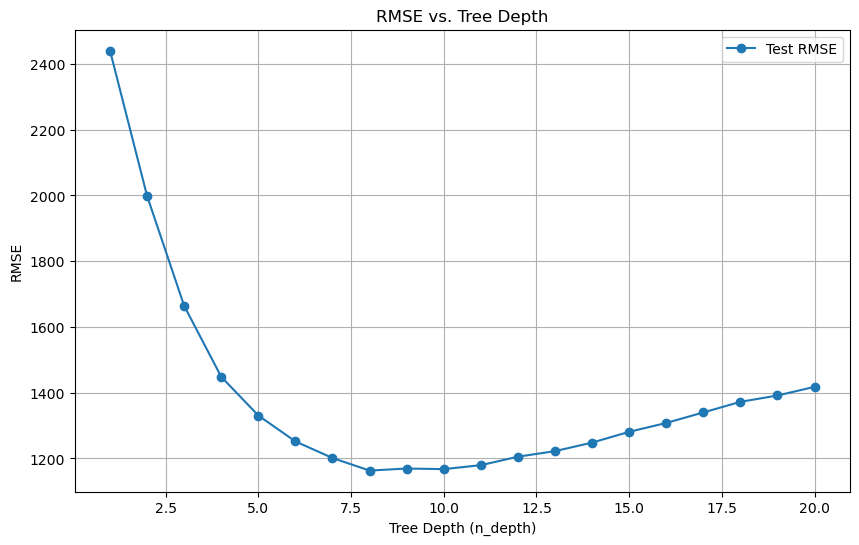

In [523]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

max_depth = range(1, 21)  # Depth values from 1 to 20
tree_test = []

# Loop over each depth value
for depth in max_depth:
    model_tree = DecisionTreeRegressor(max_depth=depth)
    model_tree.fit(X_train,y_train)
    
    # Calculate RMSE for test set
    pred_tree_test = model_tree.predict(X_test)
    mse_tree = mean_squared_error(y_test, pred_tree_test)
    tree_test.append(np.sqrt(mse_tree))

# Plot RMSE
plt.figure(figsize=(10, 6))
plt.plot(max_depth, tree_test, label="Test RMSE", marker='o')  # x-axis as n_depth
plt.ylabel("RMSE")
plt.xlabel("Tree Depth (n_depth)")
plt.title("RMSE vs. Tree Depth")
plt.legend()
plt.grid(True)
plt.show()

In [524]:
tree_model = DecisionTreeRegressor(max_depth = 8) 
tree_model.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=8)

In [525]:
tree_pred = tree_model.predict(X_test)

In [526]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R2 value is = ",round(r2_score(y_test, tree_pred),2))
mse = mean_squared_error (y_test, tree_pred)
mae = mean_absolute_error (y_test, tree_pred)
print("The mse of the model is = ",mse)
print("The root mse of the model is = ",np.sqrt(mse))
print("The mean absolute error of the model is = ",mae)

R2 value is =  0.86
The mse of the model is =  1352756.926312089
The root mse of the model is =  1163.080790965137
The mean absolute error of the model is =  784.962398486265


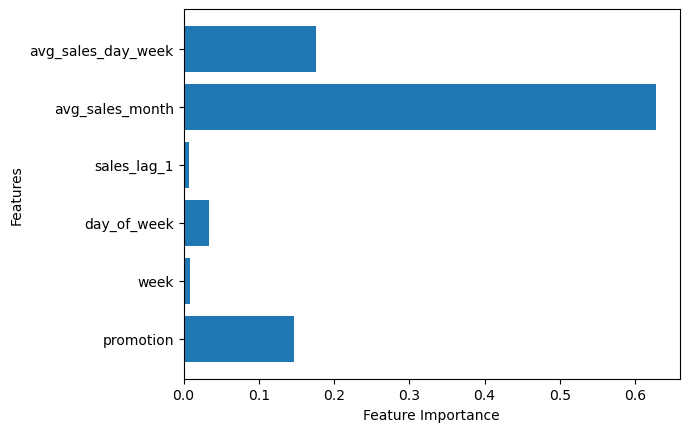

In [527]:
importances = tree_model.feature_importances_
feature_names = X.columns

plt.barh(feature_names, importances)
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight') 
plt.show()

### Improve the model (Gradient Boosting)

In [528]:
# TimeSeriesSplit for cross-validation because it respects the temporal nature of the data, prevents data leakage, 
# and better simulates real-world forecasting scenarios.

from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Model definition using Gradient Boosting Regressor
model = GradientBoostingRegressor(random_state=42)

# Parameter grid for Gradient Boosting
param_grid = {
    'n_estimators': [80,100,120],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [7,8],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1, 2]}

# TimeSeriesSplit Cross-Validation
tscv = TimeSeriesSplit(n_splits=5)

# RandomizedSearchCV for hyperparameter tuning
random_search = RandomizedSearchCV(estimator=model, param_distributions=param_grid, n_iter=20, cv=tscv, 
                                   scoring='neg_mean_squared_error', verbose=2, random_state=42, n_jobs=-1)

# Fit the model
random_search.fit(X_train, y_train)

# Best model
best_model = random_search.best_estimator_

Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [529]:
random_search.best_params_ 

{'n_estimators': 80,
 'min_samples_split': 4,
 'min_samples_leaf': 2,
 'max_depth': 7,
 'learning_rate': 0.05}

In [530]:
# Load the trained model
import joblib
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']

In [531]:
best_model.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, max_depth=7, min_samples_leaf=2,
                          min_samples_split=4, n_estimators=80,
                          random_state=42)

In [532]:
# Predict on test data
y_pred_test = best_model.predict(X_test)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R2 value is = ",round(r2_score(y_test, y_pred_test),2))
mse = mean_squared_error (y_test, y_pred_test)
mae = mean_absolute_error (y_test, y_pred_test)
print("The mse of the model is = ",mse)
print("The root mse of the model is = ",np.sqrt(mse))
print("The mean absolute error of the model is = ",mae)

R2 value is =  0.88
The mse of the model is =  1126667.6569504046
The root mse of the model is =  1061.4460216847604
The mean absolute error of the model is =  701.1081012284984


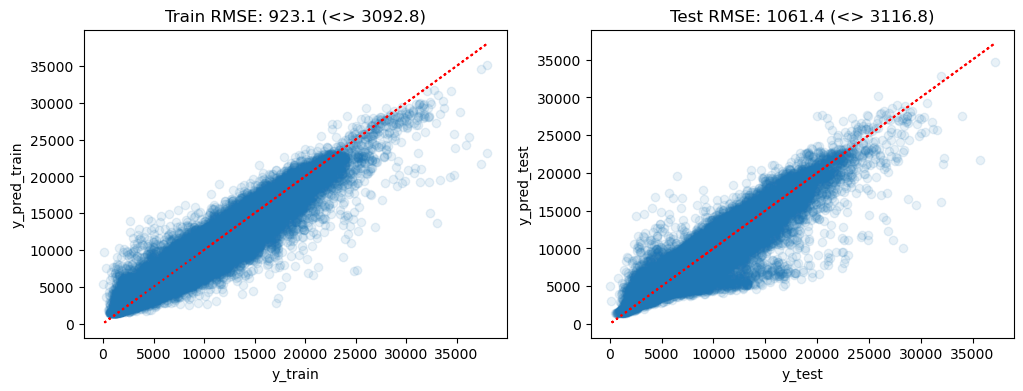

In [533]:
# Make predictions
y_pred_train = best_model.predict(X_train)
y_pred_test = best_model.predict(X_test)

# Make baseline predictions
y_pred_train_baseline = np.ones_like(y_train) * y_train.mean()
y_pred_test_baseline = np.ones_like(y_test) * y_train.mean()

# Measure train, test, and baseline performance
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train)).round(1)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test)).round(1)

rmse_train_baseline = np.sqrt(mean_squared_error(y_train, y_pred_train_baseline)).round(1)
rmse_test_baseline = np.sqrt(mean_squared_error(y_test, y_pred_test_baseline)).round(1)

# Create performance report 
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 4))

# Train set scatter plot
title1 = 'Train RMSE: {} (<> {})'.format(rmse_train, rmse_train_baseline) 
ax1.set(title=title1, xlabel='y_train', ylabel='y_pred_train')
ax1.plot(y_train, y_train, color='red', linestyle=':')
ax1.scatter(y_train, y_pred_train, alpha=0.1)

# Test set scatter plot
title2 = 'Test RMSE: {} (<> {})'.format(rmse_test, rmse_test_baseline)
ax2.set(title=title2, xlabel='y_test', ylabel='y_pred_test')
ax2.plot(y_test, y_test, color='red', linestyle=':')
ax2.scatter(y_test, y_pred_test, alpha=0.1)

# Save and show the plot
plt.savefig('performance_rmse.png', dpi=300, bbox_inches='tight')
plt.show()

np.ones_like(y_train): 

     Creates an array with the same shape as y_train, filled with ones.
* y_train.mean(

       Multiplies every element in the array by the mean of the target variable in the training set (y_train.mean()        This creates a baseline model where every prediction is equal to the mean of the training data.

    

    The baseline serves as a simple benchmark for the    el.
    If your model's predictions aren't significantly better than predicting the mean, your model may not be addi

Model Performance vs. Baseline:

    Compares the RMSE of the model's predictions to the baseline RMSE for both train and test data.
    If the model's RMSE is close to the baseline RMSE, it might indicate the model is not learning meaningful patterns.

Overfitting or Underfitting:

    Large differences between rmse_train and rmse_test could indicate overfitting (model performs well on train but poorly on test).
    High RMSE for both train and test suggests underfitting (model isn’t complex enough).

Scatter Plots for Visual Insights:

    Helps visualize how well the model’s predictions align with actual values.
    Patterns like clustering far from the diagonal or wide spreads indicate areas for improvement.ng value.

In [534]:
rmse_test

1061.4

In [535]:
rmse_test_baseline

3116.8

In [540]:
y_pred_test_baseline

array([6834.17037051, 6834.17037051, 6834.17037051, ..., 6834.17037051,
       6834.17037051, 6834.17037051])

### Apply model to production

In [495]:
import joblib
model = joblib.load('best_model.pkl')

In [496]:
# Make predictions on the filtered data
y_pred_prod = model.predict(X_prod)

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
print("R2 value is = ",round(r2_score(y_prod, y_pred_prod),2))
mse = mean_squared_error (y_prod, y_pred_prod)
mae = mean_absolute_error (y_prod, y_pred_prod)
print("The mse of the model is = ",mse)
print("The root mse of the model is = ",np.sqrt(mse))
print("The mean absolute error of the model is = ",mae)

R2 value is =  0.88
The mse of the model is =  1162808.4200500036
The root mse of the model is =  1078.3359495305735
The mean absolute error of the model is =  733.0737205154238


#### Save predictions

In [541]:
# Create a copy of the full dataset
df_complete = df_model.copy()

# Add actual values and predictions for the training set
df_complete.loc[train_mask, 'y_train'] = y_train

# Add actual values and predictions for the test set
df_complete.loc[test_mask, 'y_test'] = y_test
df_complete.loc[test_mask, 'y_pred_test'] = y_pred_test  # predictions for testing

# Add actual values and predictions for the production set
df_complete.loc[prod_mask, 'y_prod'] = y_prod
df_complete.loc[prod_mask, 'y_pred_prod'] = y_pred_prod  # predictions for production

# Optionally, sort by date to keep everything in chronological order
df_complete = df_complete.sort_values(by='date')

df_complete

,store_id,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales,day,...,quarter,week,sales_lag_1,avg_sales_month,avg_sales_day_week,y_train,y_test,y_pred_test,y_prod,y_pred_prod
Index,,,,,,,,,,,,,,,,,,,,,
580156,676,2,2013-01-01,777,1,0,1,1,3821,1,...,1,1,0.0,3714.250000,0.000000,3821.0,NaN,NaN,NaN,NaN
512628,530,2,2013-01-01,532,1,0,1,1,2907,1,...,1,1,0.0,2507.533333,0.000000,2907.0,NaN,NaN,NaN,NaN
288050,85,2,2013-01-01,619,1,0,1,1,4220,1,...,1,1,0.0,6583.210526,0.000000,4220.0,NaN,NaN,NaN,NaN
397229,262,2,2013-01-01,2875,1,0,1,1,17267,1,...,1,1,0.0,18166.958333,0.000000,17267.0,NaN,NaN,NaN,NaN
338008,335,2,2013-01-01,482,1,0,1,1,2401,1,...,1,1,0.0,11940.000000,0.000000,2401.0,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15158,965,5,2015-07-31,1013,1,1,0,1,9958,31,...,3,31,9098.0,7939.058824,8139.057143,NaN,NaN,NaN,9958.0,8952.736594
152766,962,5,2015-07-31,1119,1,1,0,1,9370,31,...,3,31,7332.0,6760.529412,6977.627907,NaN,NaN,NaN,9370.0,7613.625763
638672,353,5,2015-07-31,1851,1,1,0,1,7851,31,...,3,31,6514.0,6765.100000,5766.675000,NaN,NaN,NaN,7851.0,7171.417903


In [542]:
df_complete.to_csv('complete_with_predictions.csv', index=False)  